In [1]:

import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml


## Global Variables

In [2]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [3]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)
scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')


In [4]:
inter_dim_size = 40 #required for interpolation layer

In [5]:

class DataGeneratorClimInv(DataGenerator):
    
    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, normalize_flag=True,
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,                 
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5):
        
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off,normalize_flag) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if rh_trans:
            self.qv2rhLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_subRH,inp_divRH,hyam,hybm)
        
        if lhflx_trans:
            self.lhflxLayer = LhflxTransNumpy(self.inp_sub,self.inp_div,hyam,hybm)
            
        if t2tns_trans:
            self.t2tnsLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_subTNS,inp_divTNS,hyam,hybm)
            
        if scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
                    
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
        
            
        
    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result) 
            
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)

        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            


        return X_result,Y    
    
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result)  
        
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)

        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            

        return X_result

## Data Generators

### Data Generator using RH

In [6]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [7]:
train_gen_RH = DataGenerator(
    data_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For positve sepearation (required since we are going to use scaling)

In [8]:
TRAINFILE_RH = 'PosCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'PosCRH_CI_RH_M4K_NORM_norm.nc'

train_gen_RH_pos = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For negative sepearation

In [9]:
TRAINFILE_RH = 'NegCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'NegCRH_CI_RH_M4K_NORM_norm.nc'

train_gen_RH_neg = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Data Generator using TNS

In [10]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [11]:
train_gen_TNS = DataGenerator(
    data_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For positive 

In [12]:
TRAINFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_norm.nc'

train_gen_TNS_pos = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For negative 

In [13]:
TRAINFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_norm.nc'

train_gen_TNS_neg = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Data Generator Combined 

In [14]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [15]:
## this won't be used just to show we can use it overall
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

train_gen = DataGeneratorClimInv(
    data_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div
)

valid_gen = DataGeneratorClimInv(
    data_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div
)

In [16]:
train_gen[0][0].shape

(1024, 179)

#### For positive

In [17]:
TRAINFILE = 'PosCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'PosCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'PosCRH_CI_SP_M4K_valid.nc'

train_gen_pos = DataGeneratorClimInv(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
    inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
    is_continous=True
)

valid_gen_pos = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
    inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
    is_continous=True
)

In [18]:
train_gen_pos[0][0]

array([[-0.05502965, -0.04381603, -0.08606689, ...,  0.03937433,
         0.01822245,  0.        ],
       [-0.05510267, -0.04427684, -0.09288125, ...,  0.03824062,
         0.01769776,  0.        ],
       [-0.05515486, -0.04450944, -0.10379731, ...,  0.04390273,
         0.02031819,  0.        ],
       ...,
       [-0.05472876, -0.04278308, -0.09131577, ...,  0.03994883,
         0.01848833,  0.        ],
       [-0.05513385, -0.0443101 , -0.0988667 , ...,  0.04541129,
         0.02101635,  0.        ],
       [-0.05517165, -0.04451711, -0.10461064, ...,  0.04624114,
         0.02140041,  0.        ]])

#### For Negative

In [19]:
TRAINFILE = 'NegCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'NegCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'NegCRH_CI_SP_M4K_valid.nc'

### we don't scale this network
train_gen_neg = DataGeneratorClimInv(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
    inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
    is_continous=True,
    scaling=False
)

valid_gen_neg = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
    inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
    is_continous=True,
    scaling=False
)

## Building the Model

### For Positive

In [20]:
inp = Input(shape=(179,)) ## input after rh and tns transformation
offset = 65
inp_TNS = inp[:,offset:offset+2*inter_dim_size+4]
offset = offset+2*inter_dim_size+4
lev_tilde_before = inp[:,offset:offset+30]
offset = offset+30

densout = Dense(128, activation='linear')(inp_TNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
denseout = Dense(2*inter_dim_size+4, activation='linear')(densout)
lev_original_out = reverseInterpLayer(inter_dim_size)([denseout,lev_tilde_before])
out = ScaleOp(OpType.PWA.value,
              inp_subQ=train_gen_pos.input_transform.sub, 
              inp_divQ=train_gen_pos.input_transform.div,
              )([inp,lev_original_out])
model_pos = tf.keras.models.Model(inp, out)

In [21]:
model_pos.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 179)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 84)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          10880       tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

In [24]:
model_pos.compile(tf.keras.optimizers.Adam(), loss=mse)

In [25]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/Comnined/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+'Pos_combined_Lh.hdf5',save_best_only=True, monitor='val_loss', mode='min')
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=1000,embeddings_freq=1)

In [ ]:
Nep = 25
# model_pos.load_weights(path_HDF5+'Pos_Scaled_half_Vertical.hdf5')
model_pos.fit_generator(train_gen_pos, epochs=Nep, validation_data=valid_gen_pos,\
              callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/25
Instructions for updating:
Use tf.identity instead.
9144/9144 [==============================] - 3232s 353ms/step - loss: 622.4291 - val_loss: 539.2126
Epoch 2/25
9144/9144 [==============================] - 1418s 155ms/step - loss: 548.5059 - val_loss: 516.3526
Epoch 3/25
9144/9144 [==============================] - 1434s 157ms/step - loss: 535.1495 - val_loss: 513.2360
Epoch 4/25
9144/9144 [==============================] - 2352s 257ms/step - loss: 528.2094 - val_loss: 507.0541
Epoch 5/25
9144/9144 [==============================] - 2540s 278ms/step - loss: 523.9272 - val_loss: 502.3990
Epoch 6/25
3353/9144 [==========>...................] - ETA: 8:08 - loss: 521.0989

### For Negative

In [35]:
inp = Input(shape=(178,)) ## input after rh and tns transformation
offset = 64
inp_TNS = inp[:,offset:offset+2*inter_dim_size+4]
offset = offset+2*inter_dim_size+4
lev_tilde_before = inp[:,offset:offset+30]
offset = offset+30

densout = Dense(128, activation='linear')(inp_TNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
denseout = Dense(2*inter_dim_size+4, activation='linear')(densout)
lev_original_out = reverseInterpLayer(inter_dim_size)([denseout,lev_tilde_before])

model_neg = tf.keras.models.Model(inp, lev_original_out)

In [36]:
model_neg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 178)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 84)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          10880       tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

In [37]:
model_neg.compile(tf.keras.optimizers.Adam(), loss=mse)

In [38]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/Comnined/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_neg = ModelCheckpoint(path_HDF5+'Neg_combined_lh.hdf5',save_best_only=True, monitor='val_loss', mode='min')
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=1000,embeddings_freq=1)

In [ ]:
Nep = 10
model_neg.load_weights(path_HDF5+'Neg_combined_lh.hdf5')
model_neg.fit_generator(train_gen_neg, epochs=Nep, validation_data=valid_gen_neg,\
              callbacks=[earlyStopping, mcp_save_neg])

Epoch 1/10
Instructions for updating:
Use tf.identity instead.
32231/32231 [==============================] - 7535s 234ms/step - loss: 306.4555 - val_loss: 302.7003
Epoch 2/10
10012/32231 [========>.....................] - ETA: 56:13 - loss: 304.4983

['PHQ', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS']

## Model Diagnoistic

In [20]:
##model class to load the trained model. used during model diagnostics.
## use this only if we are adding scaling or interpolation layer in the network. Note. scaling is compulsion for this
## we can toggle interpolation layer
class ClimateNet:
    def __init__(self,pos_model,neg_model,dict_lay,subQ,divQ,interpolate,temp=2):
        self.pos_model = load_model(pos_model,custom_objects=dict_lay)
        self.neg_model = load_model(neg_model,custom_objects=dict_lay)
        self.subQ,self.divQ = np.array(subQ),np.array(divQ)
        scaling=False
        rh_trans=True
        t2tns_trans=True
        
        if interpolate==False:
            rh_trans=False
            t2tns_trans=False
        in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
        out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
        self.pos_data_gen = DataGeneratorClimInv(
                            data_fn = TRAINDIR+'PosCRH_CI_SP_M4K_train_shuffle.nc',
                            input_vars = in_vars,
                            output_vars = out_vars,
                            norm_fn = TRAINDIR+'PosCRH_CI_SP_M4K_NORM_norm.nc',
                            input_transform = ('mean', 'maxrs'),
                            output_transform = scale_dict,
                            batch_size=1024,
                            shuffle=True,
                            normalize_flag=True,
                            lev=lev,
                            hyam=hyam,hybm=hybm,
                            inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
                            inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
                            is_continous=True,
                            interpolate=interpolate,
                            rh_trans=rh_trans,
                            t2tns_trans=t2tns_trans
            
                        )
        
        if temp==1:
            scaling=True
        self.neg_data_gen = DataGeneratorClimInv(
                            data_fn = TRAINDIR+'NegCRH_CI_SP_M4K_train_shuffle.nc',
                            input_vars = in_vars,
                            output_vars = out_vars,
                            norm_fn = TRAINDIR+'NegCRH_CI_SP_M4K_NORM_norm.nc',
                            input_transform = ('mean', 'maxrs'),
                            output_transform = scale_dict,
                            batch_size=1024,
                            shuffle=True,
                            normalize_flag=True,
                            lev=lev,
                            hyam=hyam,hybm=hybm,
                            inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
                            inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
                            is_continous=True,
                            interpolate=interpolate,
                            scaling=scaling,
                            rh_trans=rh_trans,
                            t2tns_trans=t2tns_trans
                        )

    
    def reorder(self,op_pos,op_neg,mask):
        op = []
        pos_i=0
        neg_i = 0
        for m in mask:
            if m:
                op.append(op_pos[pos_i])
                pos_i += 1
            else:
                op.append(op_neg[neg_i])
                neg_i += 1
        return np.array(op)
                
                
    def predict_on_batch(self,inp):
        #inp = batch x 179
        inp_de = inp[:,:64]*self.divQ + self.subQ
        
        mask = ScalingNumpy(hyam,hybm).crh(inp_de)> 0.8
        pos_inp = inp[mask]
        neg_inp = inp[np.logical_not(mask)]
        ### for positive
        pos_inp = pos_inp*self.divQ + self.subQ
        pos_inp = self.pos_data_gen.transform(pos_inp)
        op_pos = self.pos_model.predict_on_batch(pos_inp)
        neg_inp = neg_inp*self.divQ + self.subQ
        neg_inp = self.neg_data_gen.transform(neg_inp)
        op_neg = self.neg_model.predict_on_batch(neg_inp)
        op = self.reorder(np.array(op_pos),np.array(op_neg),mask)
        return op
        



In [21]:
def load_combined_model(path_pos,path_neg,dict_lay,config_fn, data_fn,nlat=64, nlon=128, nlev=30, ntime=48,interpolate=True,temp=2):
    with open(config_fn, 'r') as f:
        config = yaml.load(f)
    out_scale_dict = load_pickle(config['output_dict'])
    ngeo = nlat * nlon
    train_gen = DataGenerator(
            data_fn = data_fn,
            input_vars=config['inputs'],
            output_vars=config['outputs'],
            norm_fn=config['data_dir'] + config['norm_fn'],
            input_transform=(config['input_sub'], config['input_div']),
            output_transform=out_scale_dict,
            batch_size=ngeo,
            shuffle=False,
            xarray=True,
            normalize_flag=True,
            var_cut_off=config['var_cut_off'] if 'var_cut_off' in config.keys() else None
        )
    
    obj = ClimateNet(path_pos,path_neg,dict_lay,train_gen.input_transform.sub,train_gen.input_transform.div,interpolate=interpolate,temp=temp)
    return obj

In [22]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/Comnined/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_RH_TNS.hdf5','Pos_Scaled_Vertical.hdf5*Neg_Scaled_Vertical.hdf5', 'Pos_combined_Lh.hdf5*Neg_combined_lh.hdf5'] # NN to evaluate 
NNname = ['RH TNS', 'Scale Net', 'Combined LH Net'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

In [23]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [24]:

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    if '*' not in NNs:
        NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        ##only
        if 'Scaled_CRHNet' in NNs:
            pos_path,neg_path = NNs.split('*')
            NN[NNs] = load_combined_model(path_HDF5+pos_path,path_HDF5+neg_path,dict_lay,
                                         '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                          '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data,interpolate=False)
        if 'Vertical' in NNs or 'Pos_combined_Lh' in NNs:
            print(NNs)
            pos_path,neg_path = NNs.split('*')
            temp=2
            if 'Vertical' in NNs:
                temp=1
            NN[NNs] = load_combined_model(path_HDF5+pos_path,path_HDF5+neg_path,dict_lay,
                                         '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                          '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data,temp=temp)   
            
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
        


[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData//HDF5_DATA'
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog
NN name is  CI01_RH_TNS.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  Pos_Scaled_Vertical.hdf5*Neg_Scaled_Vertical.hdf5
data name is  CI_SP_M4K_valid.nc
Pos_Scaled_Vertical.hdf5*Neg_Scaled_Vertical.hdf5


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


data name is  CI_SP_P4K_valid.nc
Pos_Scaled_Vertical.hdf5*Neg_Scaled_Vertical.hdf5


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


NN name is  Pos_combined_Lh.hdf5*Neg_combined_lh.hdf5
data name is  CI_SP_M4K_valid.nc
Pos_combined_Lh.hdf5*Neg_combined_lh.hdf5


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


data name is  CI_SP_P4K_valid.nc
Pos_combined_Lh.hdf5*Neg_combined_lh.hdf5


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [30]:
lat_ind = np.arange(26,40)
# lat_ind = np.arange(57,64)

# e.g. slices of (0,7), (14,20) and (57,64)?
iinis = [500]
# iini = 414 # Initial time to sample
# iend = iini+47 # One day later
diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: diagno['truth'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: diagno['truth'][data[6:-3]][iini] = {}
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                p = np.array(p)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]

                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)



i= 0 & NNs= CI01_RH_TNS.hdf5          


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



i= 1 & NNs= Pos_Scaled_Vertical.hdf5*Neg_Scaled_Vertical.hdf5          



i= 2 & NNs= Pos_combined_Lh.hdf5*Neg_combined_lh.hdf5          


In [31]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [32]:
fz = 20
lw = 4
plt.rc('text',usetex=False)
plt.rc('font',size=fz)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

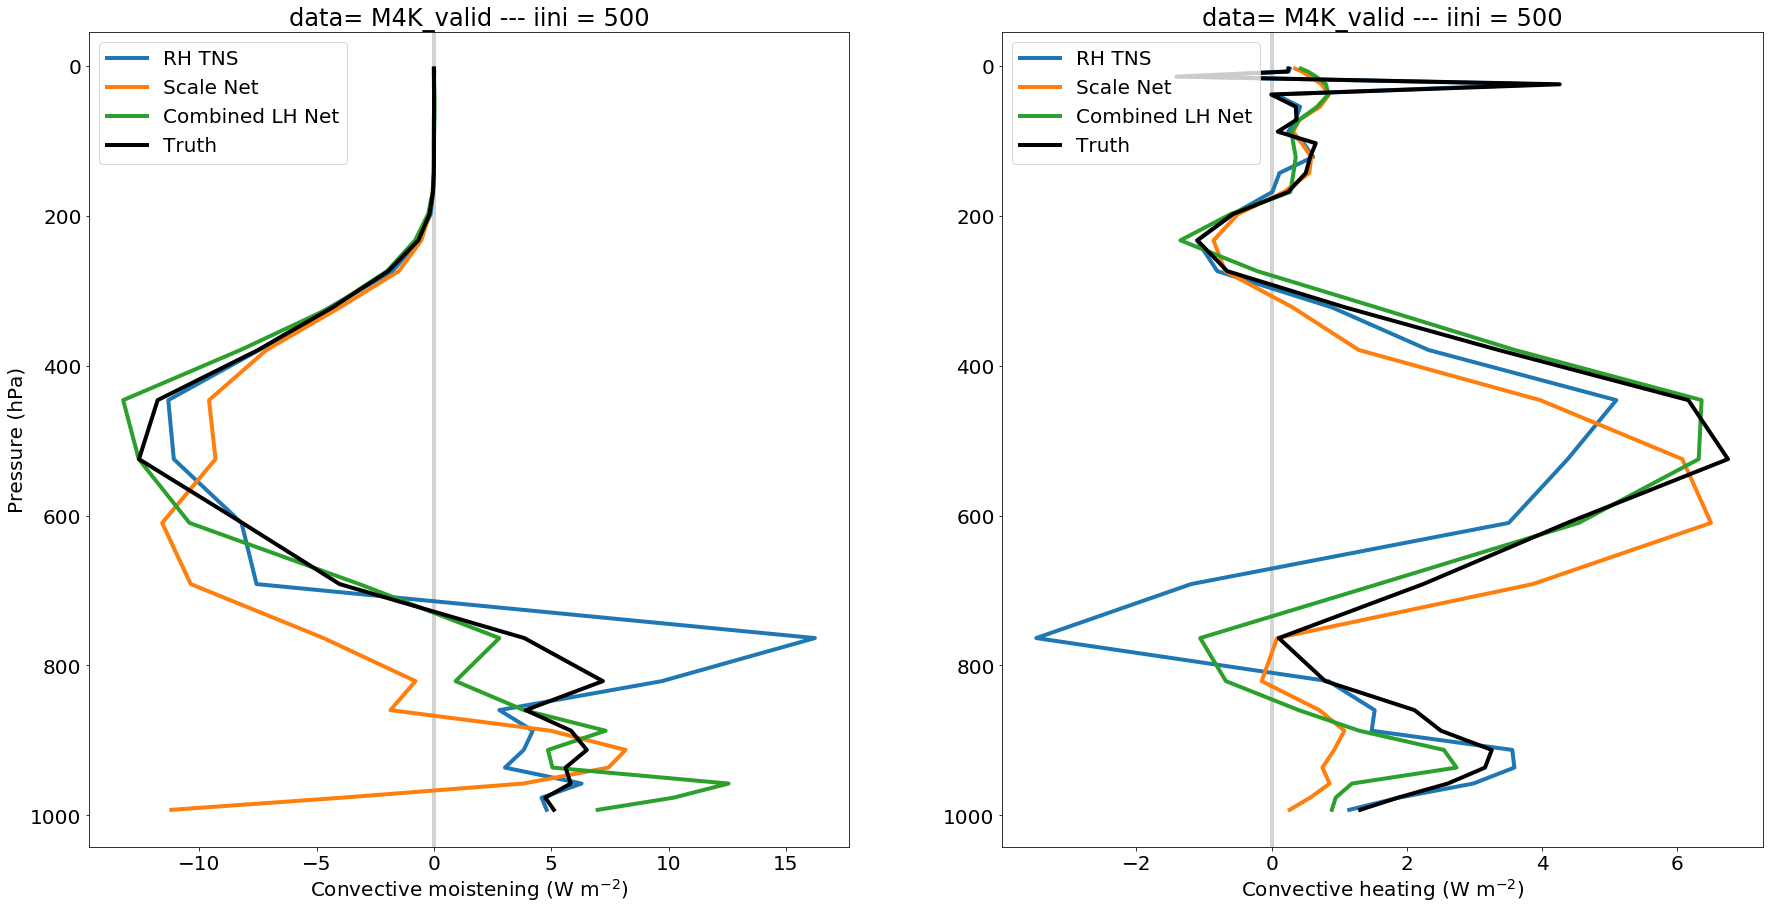

In [33]:


data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


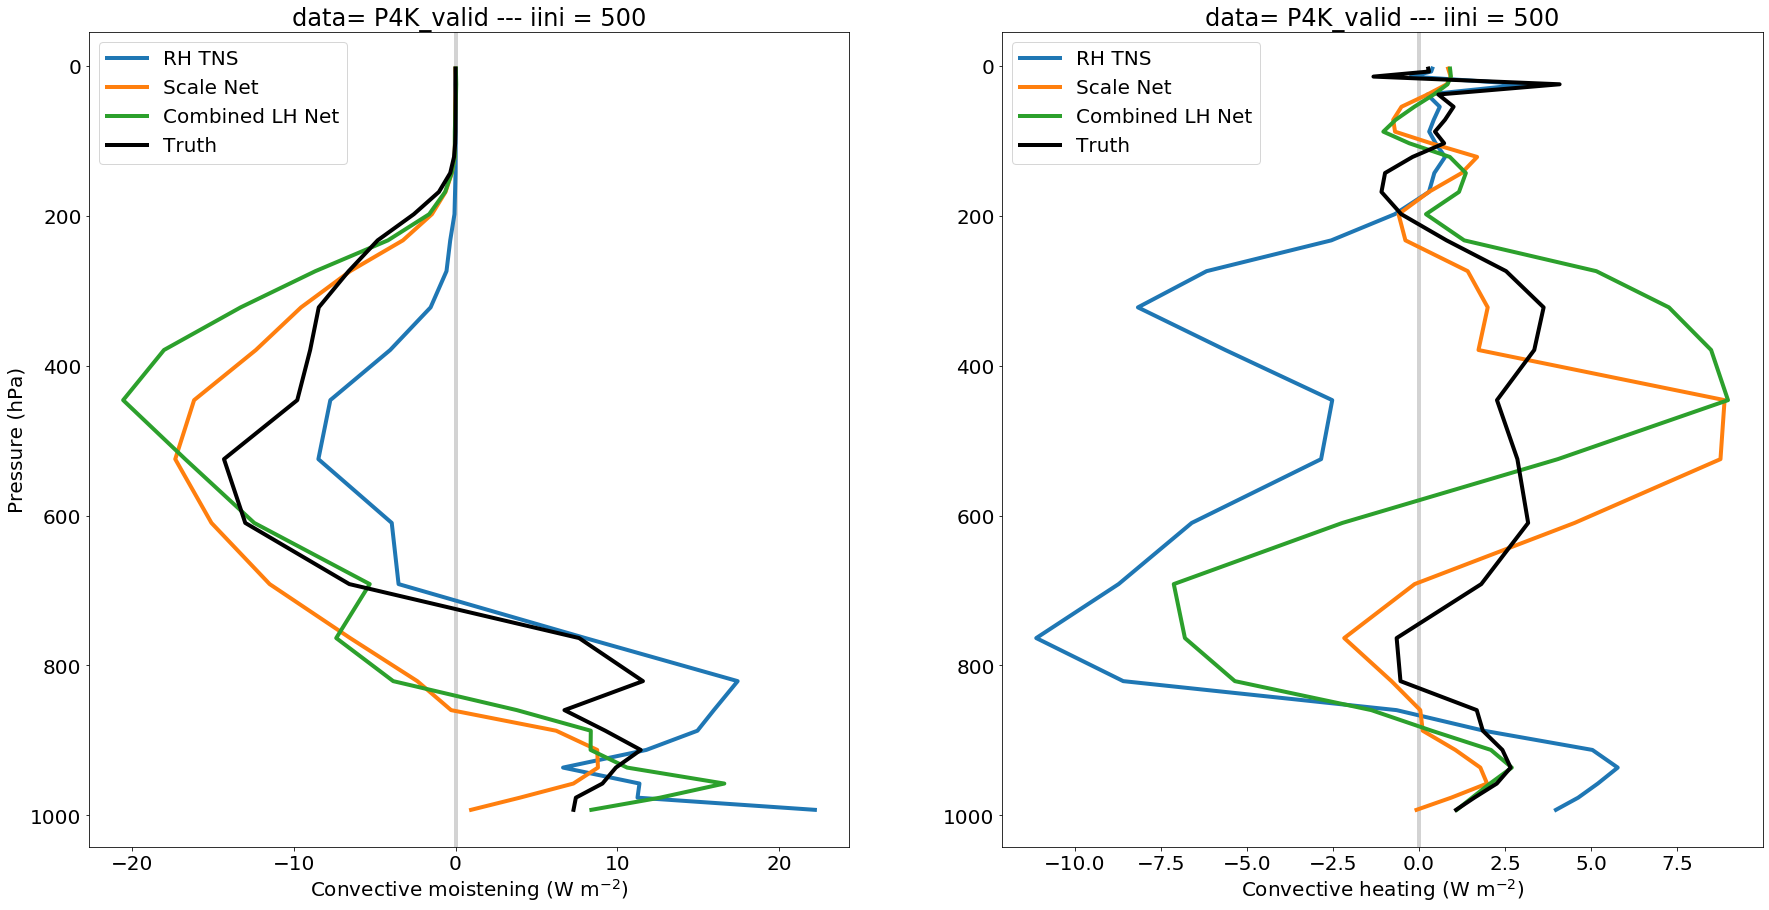

In [34]:


data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
